In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import statsmodels.tsa.arima_process as arima_process
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings("ignore")


from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import _extrapolate_trend
import pickle


# Load sunspot data

In [27]:
sunspot = pd.read_csv('Sunspots.csv')
sunspot.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [28]:
sunspot.tail()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9
3234,3234,2018-07-31,1.6


In [29]:
sunspot.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [30]:
# first change the object to datetime object for the month
# set month as index
#drop the extra month
#rename to ease name

sunspot=sunspot.set_index(pd.to_datetime(sunspot['Date']))
sunspot.drop(columns=['Unnamed: 0','Date'],axis=1,inplace=True)
sunspot.rename(columns={'Monthly Mean Total Sunspot Number':'Sunspots_values'}, inplace=True)
sunspot.head()

,Sunspots_values
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [31]:
type(sunspot)

pandas.core.frame.DataFrame

 other way

In [39]:
sunspot_sque = pd.read_csv('Sunspots.csv', index_col=[1], parse_dates=True, squeeze=True)
sunspot_sque.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
sunspot_sque.rename(columns={'Monthly Mean Total Sunspot Number':'Sunspots_values'}, inplace=True)
sunspot_sque=sunspot_sque.iloc[:,0]
sunspot_sque.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Name: Sunspots_values, dtype: float64

In [41]:
type(sunspot_sque)

pandas.core.series.Series

In [42]:
sunspot_sque.shape

(3235,)

In [43]:
sunspot_sque.size

3235

In [44]:
sunspot_sque.describe()

count    3235.000000
mean       82.481082
std        67.805190
min         0.000000
25%        24.750000
50%        68.300000
75%       122.900000
max       398.200000
Name: Sunspots_values, dtype: float64

<AxesSubplot:xlabel='Date'>

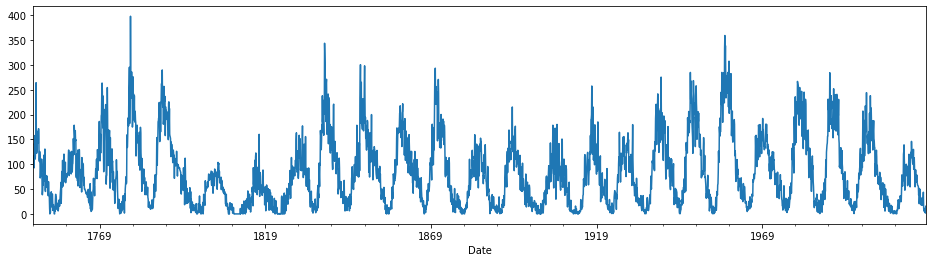

In [47]:
sunspot_sque.plot(figsize=(16,4))

<AxesSubplot:xlabel='Date'>

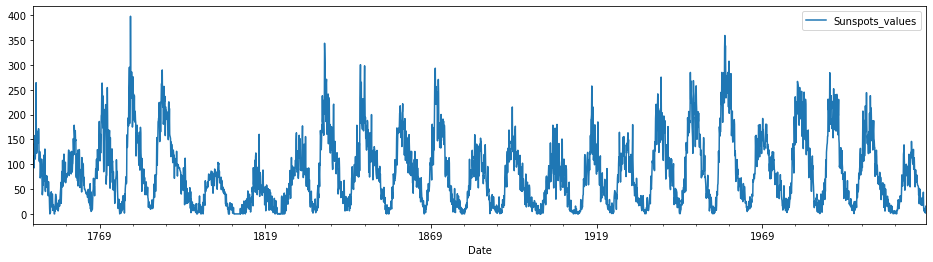

In [48]:
#plot the sunspot 
sunspot.plot(figsize=(16,4))

In [49]:
sunspot_ma=sunspot.rolling(window=2).mean()

<AxesSubplot:xlabel='Date'>

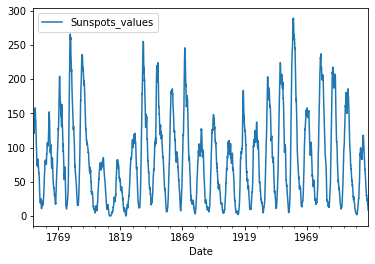

In [50]:
sunspot_ma.plot()

# Creating a baseline, naive, or initial model

Creating a baseline model is if our time series model is below this just reject it.

In [51]:
sunspot_sque

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
              ...  
2018-03-31      2.5
2018-04-30      8.9
2018-05-31     13.2
2018-06-30     15.9
2018-07-31      1.6
Name: Sunspots_values, Length: 3235, dtype: float64

In [52]:
sunspot_base=pd.concat([sunspot_sque, sunspot_sque.shift(1)], axis=1)
sunspot_base

,Sunspots_values,Sunspots_values
Date,,
1749-01-31,96.7,NaN
1749-02-28,104.3,96.7
1749-03-31,116.7,104.3
1749-04-30,92.8,116.7
1749-05-31,141.7,92.8
...,...,...
2018-03-31,2.5,10.7
2018-04-30,8.9,2.5
2018-05-31,13.2,8.9


In [58]:
# rename the data set
sunspot_base.columns=['origina_Sunspots_values','forcast_Sunspots_values']
sunspot_base

,origina_Sunspots_values,forcast_Sunspots_values
Date,,
1749-02-28,104.3,96.7
1749-03-31,116.7,104.3
1749-04-30,92.8,116.7
1749-05-31,141.7,92.8
1749-06-30,139.2,141.7
...,...,...
2018-03-31,2.5,10.7
2018-04-30,8.9,2.5
2018-05-31,13.2,8.9


In [59]:
# drop the missing value
sunspot_base.dropna(inplace=True)
sunspot_base

,origina_Sunspots_values,forcast_Sunspots_values
Date,,
1749-02-28,104.3,96.7
1749-03-31,116.7,104.3
1749-04-30,92.8,116.7
1749-05-31,141.7,92.8
1749-06-30,139.2,141.7
...,...,...
2018-03-31,2.5,10.7
2018-04-30,8.9,2.5
2018-05-31,13.2,8.9


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [61]:
sunspot_error=mean_squared_error(sunspot_base.origina_Sunspots_values,sunspot_base.forcast_Sunspots_values)
sunspot_error

760.0399288806432

In [62]:
np.sqrt(sunspot_error)

27.56882168103387

In [63]:
sunspot_error_mae=mean_absolute_error(sunspot_base.origina_Sunspots_values,sunspot_base.forcast_Sunspots_values)
sunspot_error_mae

19.384075448361166

# Split historical data and future data

In [7]:
#Use data from 1900 to 1984 to constract the model 
# Make a forcast for 1985 to 2000
#let store the information into y_hist and y_future

y_hist=sunspot.loc['1900':'1984','Sunspots_values']
y_future=sunspot.loc['1985':'2000','Sunspots_values']
y_hist

Date
1900-01-31    15.7
1900-02-28    22.8
1900-03-31    14.4
1900-04-30    26.8
1900-05-31    25.3
              ... 
1984-08-31    35.0
1984-09-30    22.6
1984-10-31    12.6
1984-11-30    26.5
1984-12-31    21.4
Name: Sunspots_values, Length: 1020, dtype: float64

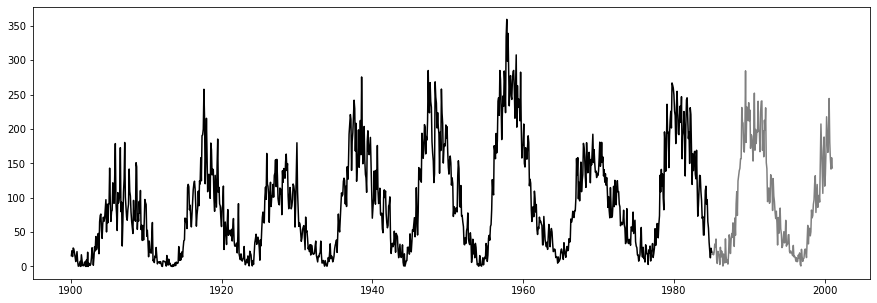

In [8]:
#plot the two datas
plt.figure(figsize=(15,5))
plt.plot(y_hist,'black')
plt.plot(y_future,'black', alpha=0.5)

The maximum smoothed sunspot number (monthly number of sunspots averaged over a twelve-month period)
observed during the solar cycle was 120.8 (March 2000), and the minimum was 1.7

Their number varies according to the approximately 11-year solar cycle

Individual sunspots or groups of sunspots may last anywhere from a few days to a few months, but eventually decay. Sunspots expand and contract as they move across the surface of the Sun


# Extract the trend

In [9]:
#specify the period of the solar sunspot
period= 128   # close to 11*12  month

#Build the filter based on the period of the soalr sunspot

filt=np.ones(period+1)  # the length is 129
filt[0]=0.5
filt[-1]=0.5
filt/=period
filt

array([0.00390625, 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 ,
       0.0078125 , 0.0078125 , 0.0078125 , 0.0078125 , 0.00781

In [10]:
sum(filt)

1.0

The sum one mean,the filter does not affect to the mean of the historical data

In [11]:
#Now run the historical data through the filter to get the trend
trend=convolution_filter(y_hist,filt)
trend

Date
1900-01-31   NaN
1900-02-28   NaN
1900-03-31   NaN
1900-04-30   NaN
1900-05-31   NaN
              ..
1984-08-31   NaN
1984-09-30   NaN
1984-10-31   NaN
1984-11-30   NaN
1984-12-31   NaN
Name: Sunspots_values, Length: 1020, dtype: float64

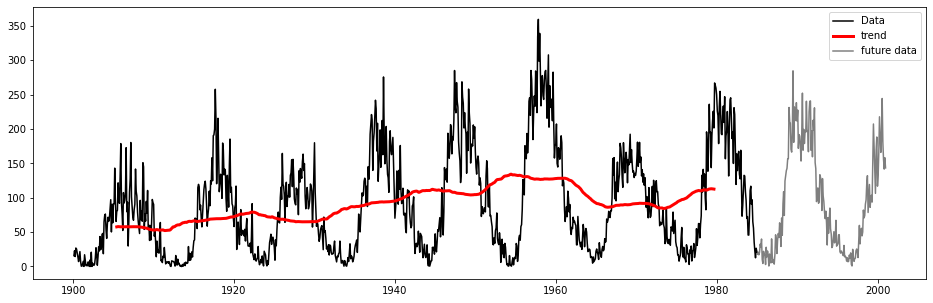

In [12]:
#Plot trend, historica and future data
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='Data')
plt.plot(trend,'r',lw=3, label='trend')
plt.plot(y_future,'k', alpha=0.5,label='future data')
plt.legend()

In [13]:
#Our trend is not going all the way to the begining and ending of the historical period
#to do that we need to apply an extrapolate method
trend=_extrapolate_trend(trend,period+1)
trend

Date
1900-01-31     49.168829
1900-02-28     49.240788
1900-03-31     49.312746
1900-04-30     49.384704
1900-05-31     49.456663
                 ...    
1984-08-31    122.154769
1984-09-30    122.362121
1984-10-31    122.569472
1984-11-30    122.776824
1984-12-31    122.984176
Name: Sunspots_values, Length: 1020, dtype: float64

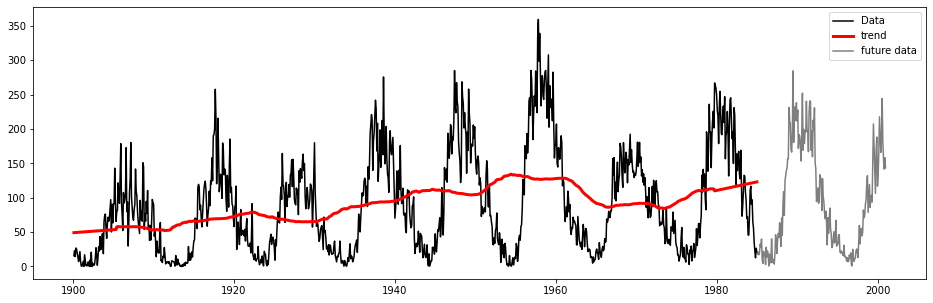

In [14]:
#Plot extrapolated trend, historica and future data
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='Data')
plt.plot(trend,'r',lw=3, label='trend')
plt.plot(y_future,'k', alpha=0.5,label='future data')
plt.legend()

# Detrend the data

Detrending a time series is to remove the trend component from a time series


Detrending a time series is to remove the trend component from a time series

1. Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.

2. Subtract the trend component obtained from time series decomposition we saw earlier.

3. Subtract the mean

4. Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.


In [15]:
detrend =y_hist-trend
detrend=detrend.to_numpy()
detrend

array([ -33.4688291 ,  -26.44078752,  -34.91274593, ..., -109.96947229,
        -96.27682408, -101.58417587])

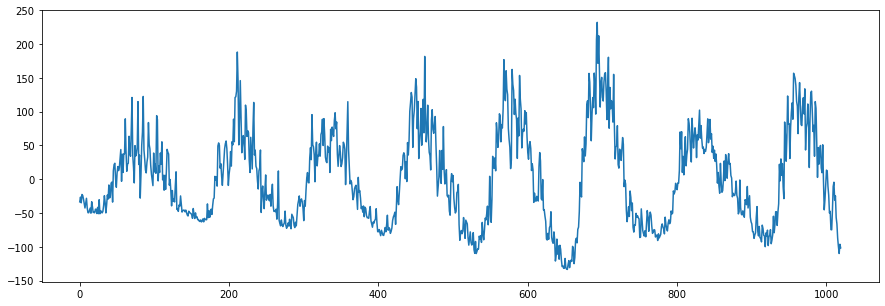

In [16]:
plt.figure(figsize=(15,5))
plt.plot(detrend)

# Split the historical data into seasons

this can be done by identify when the lowest sunspot grouph touchs to zero 

In [17]:
#do it manually to get the numbers
low_index=[20,155,284,405,529,650,775, 917]

#pass those numbers to the index to get the corresponding dates
lows=y_hist.index[low_index]
lows

DatetimeIndex(['1901-09-30', '1912-12-31', '1923-09-30', '1933-10-31',
               '1944-02-29', '1954-03-31', '1964-08-31', '1976-06-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

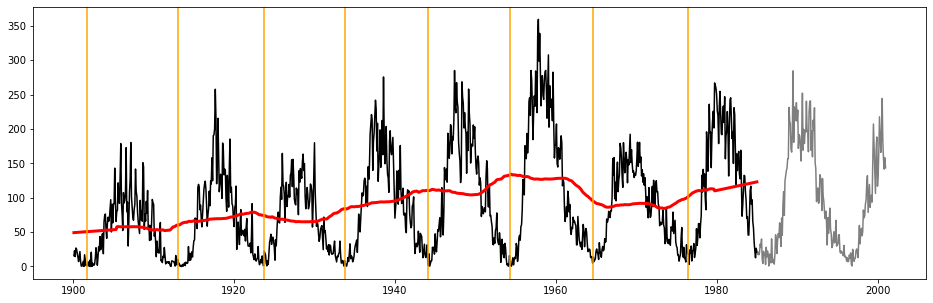

In [18]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(trend,'r',lw=3)
plt.plot(y_future,'k', alpha=0.5)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange')

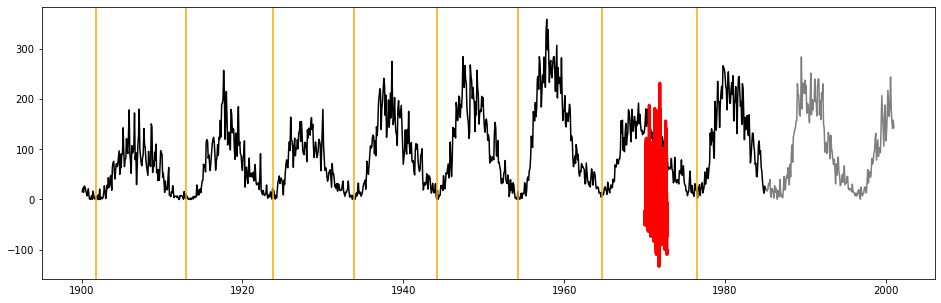

In [19]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(detrend,'r',lw=3)
plt.plot(y_future,'k', alpha=0.5)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange')

# Divide the detrend data into seasons

In [20]:
period=int(np.round(np.mean(np.diff(low_index))))
period

128

In [21]:
num_hist_periods = len(lows)-1

period, num_hist_periods

(128, 7)

In [22]:
# extracting the mean of the seasons
seasonals = np.empty((period,num_hist_periods))
for p in range(num_hist_periods):
    s = detrend[low_index[p]:low_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

In [23]:
mean_seasonals

array([0.15245317, 0.14238665, 0.12574131, 0.105283  , 0.14903491,
       0.14674133, 0.18514714, 0.18804555, 0.18951791, 0.22583474,
       0.26434718, 0.20780264, 0.21251993, 0.27933764, 0.3091549 ,
       0.26771906, 0.29632457, 0.39489777, 0.33750201, 0.45196469,
       0.61773441, 0.56833486, 0.5368187 , 0.67726267, 0.75261848,
       0.84191955, 0.90428127, 0.99148536, 0.93703296, 1.09942022,
       1.13070625, 1.05911006, 1.10465236, 1.12696012, 1.0899635 ,
       1.07256424, 1.08822674, 1.1916753 , 1.19178446, 1.43756388,
       1.44924061, 1.44191705, 1.44219408, 1.39145155, 1.28446404,
       1.36419689, 1.32494818, 1.16896261, 1.23750381, 1.27963722,
       1.46471531, 1.25858953, 1.38532946, 1.30696511, 1.50608778,
       1.51372231, 1.42252091, 1.55090341, 1.54771616, 1.23838876,
       1.48286307, 1.21721578, 1.14842164, 1.1698238 , 1.24333695,
       1.37623394, 1.23037945, 1.25451017, 1.21147816, 1.24678104,
       1.23642262, 1.19218651, 1.06021199, 1.05704021, 1.10021

In [24]:
plt.figure(figsize=(15,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p], color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',lw=3)

NameError: name 'num_seasons' is not defined

<Figure size 1080x360 with 0 Axes>

# smooth the seasonals

In [ ]:
filt_size = 9
filt = np.repeat(1.0 / filt_size, filt_size)

In [25]:
seasonals = np.empty((period,num_hist_periods))
for p in range(num_hist_periods):
    s = detrend[low_index[p]:low_index[p]+period]
    s = convolution_filter(s, filt)
    s = _extrapolate_trend(s, filt_size)
    s = (s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)


NameError: name 'filt_size' is not defined

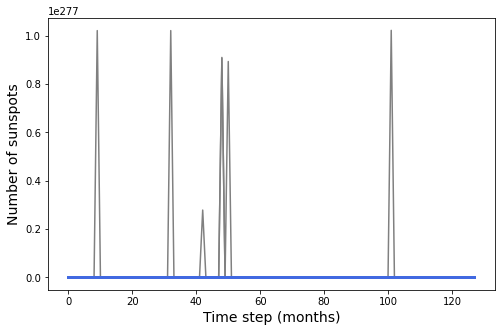

In [26]:
plt.figure(figsize=(8,5))
for p in range(num_hist_periods):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3,label='mean seasonal')
plt.xlabel('Time step (months)',fontsize=14)
plt.xlabel('Time step (months)',fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

# remove outliers

In [27]:
# remove outliers
seasonals = seasonals[:,[2,3,4]]
mean_seasonals = seasonals.mean(axis=1)

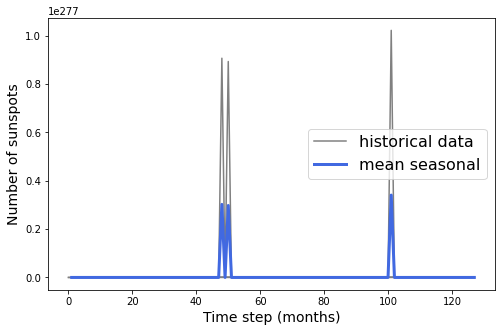

In [28]:
plt.figure(figsize=(8,5))
plt.plot(seasonals[0],color=0.5*np.ones(3),label='historical data')
plt.plot(seasonals,color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3,label='mean seasonal')
plt.xlabel('Time step (months)',fontsize=14)
plt.xlabel('Time step (months)',fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.legend(fontsize=16)
plt.show()

# Build the seasonal template

In [29]:
seasonal = pd.Series(index=y_hist.index,data=0)

for low in low_index:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]
        
        
seasonal = seasonal / np.max(seasonal)

Text(0, 0.5, 'Number of sunspots')

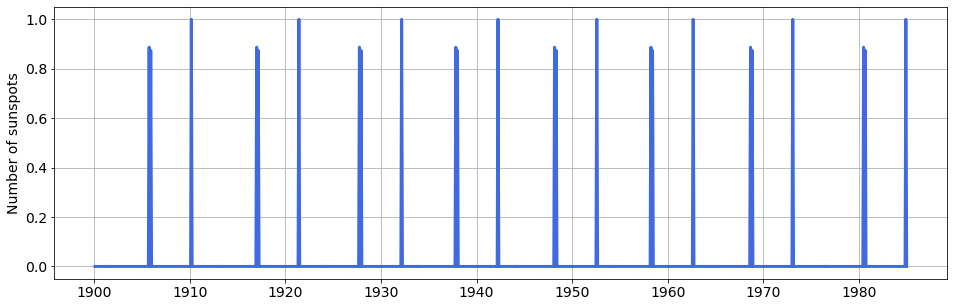

In [30]:
plt.figure(figsize=(16,5))
plt.plot(seasonal,label='trend+seasonal',color='royalblue',linewidth=3)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)

# Final Model

In [219]:
season_and_trend = 2*trend*seasonal

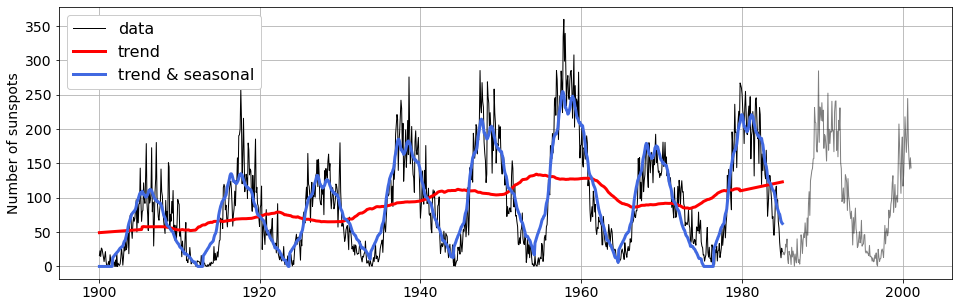

In [220]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=16,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

# Model residue

In [221]:
residue = y_hist - season_and_trend

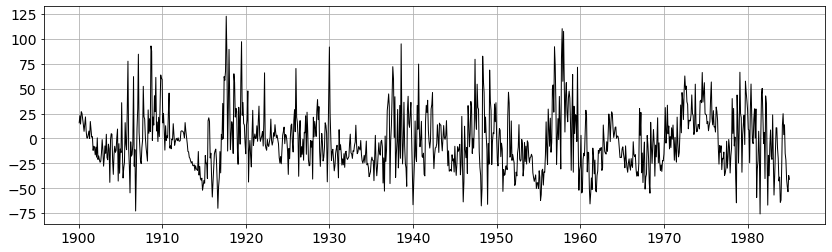

In [222]:
plt.figure(figsize=(14,4))
plt.plot(residue,'k',linewidth=1,label='model residue')
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Size of the residue`

In [223]:
MAEm=np.abs(residue).mean()
RMSEm=np.sqrt(np.square(residue).mean())
MAEm,RMSEm

(22.72635908805388, 29.218041541672676)

# Stationarity of the reidue

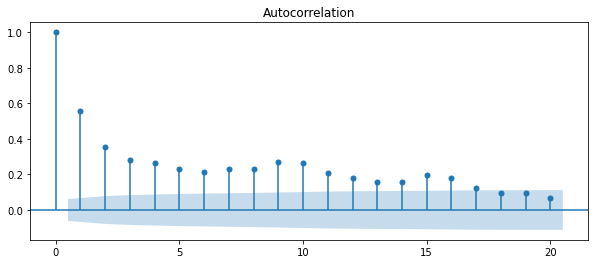

In [224]:
fig, ax=plt.subplots(figsize=(10,4))
tsaplots.plot_acf(residue,lags=20, ax=ax)
plt.show()

The residue is not stationary

In [225]:
# trend projection
yhat_trend = pd.Series(index=y_future.index, data=trend[-1])

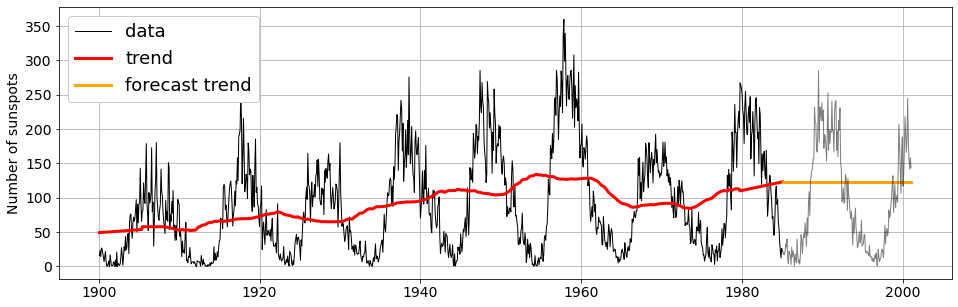

In [226]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=18,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

In [227]:
#seasonal projection
yhat_seasonal = pd.Series(index=y_future.index)
for i in range(len(yhat_seasonal)):
    yhat_seasonal[i] = seasonal[-(2*len(mean_seasonals)-i)]
yhat = 2*yhat_trend*yhat_seasonal

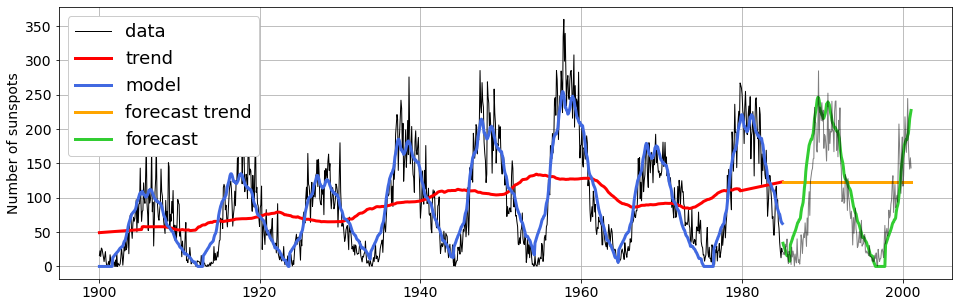

In [228]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=18,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

# Prediction Error

In [229]:
pred_error = y_future - yhat

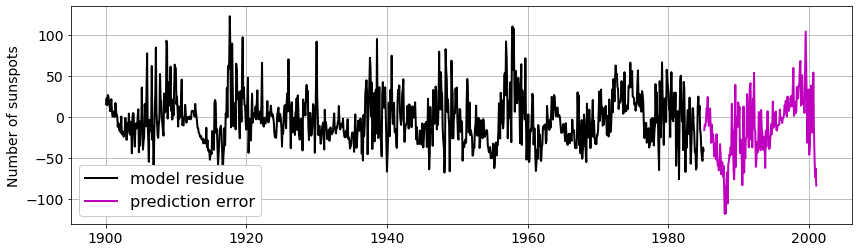

In [230]:
plt.figure(figsize=(14,4))
plt.plot(residue,'k',linewidth=2,label='model residue')
plt.plot(pred_error,'m',linewidth=2,label='prediction error')
plt.grid()
plt.legend(fontsize=16,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

# Size of the prediction error

In [231]:
MAEp=np.abs(pred_error).mean()
RMSEp=np.sqrt(np.square(pred_error).mean())
MAEp,RMSEp

(30.579767206745913, 39.01253619725411)

# Save

In [232]:
with open('decomp.pkl', 'wb') as file:
    pickle.dump( {'history': pd.DataFrame({'y_hist':y_hist,'t_and_s':season_and_trend,'ts_residue':residue}),
                  'future' : pd.DataFrame({'y_future':y_future,'yhat':yhat,'error':pred_error})} , file)